In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Outer operations

x = [1, 3, 5]
y = [2, 4]

X, Y = np.meshgrid(x, y)

In [4]:
X

array([[1, 3, 5],
       [1, 3, 5]])

In [5]:
Y

array([[2, 2, 2],
       [4, 4, 4]])

In [6]:
X * Y

array([[ 2,  6, 10],
       [ 4, 12, 20]])

In [7]:
df = pd.DataFrame(X * Y, columns=x, index=y)
df

,1,3,5
2,2,6,10
4,4,12,20


In [8]:
X + Y

array([[3, 5, 7],
       [5, 7, 9]])

In [9]:
X > Y

array([[False,  True,  True],
       [False, False,  True]])

In [10]:
# How Tall is A? Choose 2 random US adult males: if A is taller than B, how tall is A?
# 1. Use background info on male height in the US to build a prior
# 2. Build a joint prior of height for A and B
# 3. Update the prior with the data that A is taller
# 4. From the joint posterior, extract the posterior for A's height

# The average US male is 178 cm with a SD of 7.7; it's not perfectly normal, but it's close enough
# Create an array of equally spaced values from -3 to 3 SDs

mean = 178
qs = np.arange(mean-24, mean+24, 0.5)

In [11]:
from scipy.stats import norm

In [12]:
std = 7.7
ps = norm(mean, std).pdf(qs)

In [13]:
# Probability densities aren't probabilities, but putting in a Pmf and normalizing results in a discrete
# approximation of the normal dist

from empiricaldist import Pmf

In [14]:
prior = Pmf(ps, qs)
prior.normalize()

np.float64(1.9963309462450582)

<Axes: title={'center': 'Approximate distribution of male heights in US'}, xlabel='Height (cm)', ylabel='PDF'>

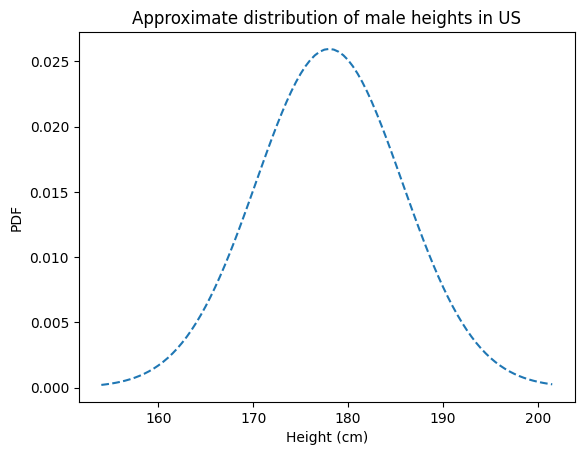

In [15]:
prior.plot(title="Approximate distribution of male heights in US", xlabel="Height (cm)", ylabel="PDF", ls="--")

In [16]:
# The joint distribution describes the probabilities of every pair of heights - Pr(A(x) and B(y)), 
# the prob that A is x cm and B is y cm tall
# If we assume the probabilities for A and B are independent, they can be computed as
# Pr(A(x) and B(y)) = Pr(A(x))*Pr(B(y))
# If we have Pmfs for A and B we can compute the joint dist as an outer product of the probs in each Pmf

def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs"""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [17]:
# In this example, A and B have the same prior

joint = make_joint(prior, prior)
joint.shape

(96, 96)

In [18]:
# If the prior is normalized, the joint prior will also be normalized

joint.to_numpy().sum()

np.float64(1.0)

In [19]:
# Visualizing the joint dist requires matplotlib's pcolormesh function

def plot_joint(joint, cmap="Blues"):
    """Plot a joint distribution with a color mesh"""
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint,
                  cmap=cmap,
                  vmax=vmax,
                  shading="nearest")
    plt.colorbar()
    plt.xlabel("A height (cm)")
    plt.ylabel("B height (cm)")

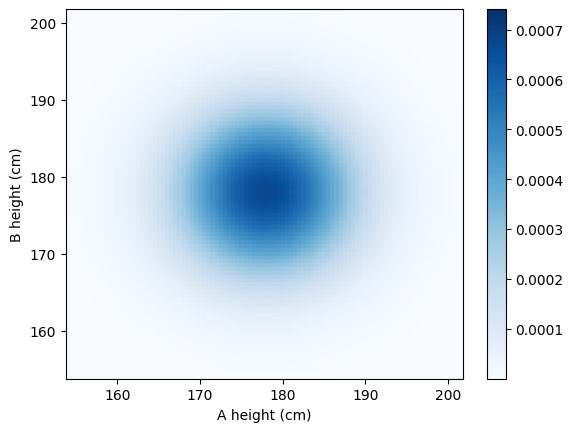

In [20]:
plot_joint(joint)

In [21]:
# Could also use a contour plot

def plot_counter(joint):
    plt.contour(joint.columns, joint.index, joint, linewidths=2)
    plt.xlabel("A height (cm)")
    plt.ylabel("B height (cm)")

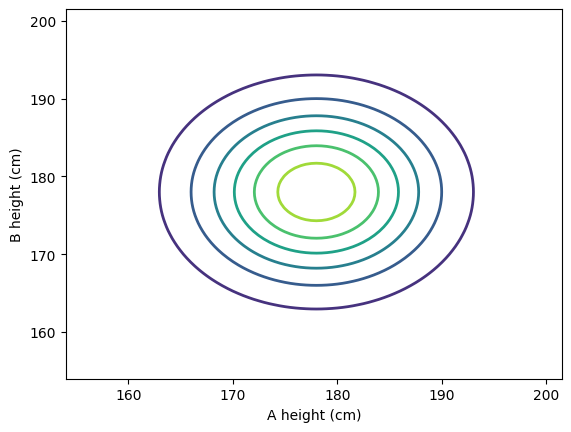

In [22]:
plot_counter(joint)

In [23]:
# Now we have a joint prior, and can update it with the data
# To compute the likelihood of every pair of quantities, we can extract column and row labels from the prior

x = joint.columns
y = joint.index

X, Y = np.meshgrid(x, y)

A_taller = (X > Y)
A_taller.dtype

dtype('bool')

In [24]:
# Computing likelihoods requires creating an array with 1 where A_taller=True, and 0 otherwise

a = np.where(A_taller, 1, 0)

likelihood = pd.DataFrame(a, index=x, columns=y)

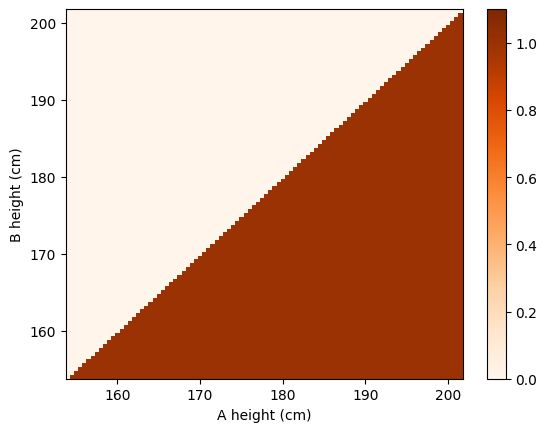

In [25]:
plot_joint(likelihood, cmap="Oranges")

In [26]:
# Normalizing the posterior uses this function

def normalize(joint):
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [27]:
posterior = joint * likelihood
normalize(posterior)

np.float64(0.49080747821526977)

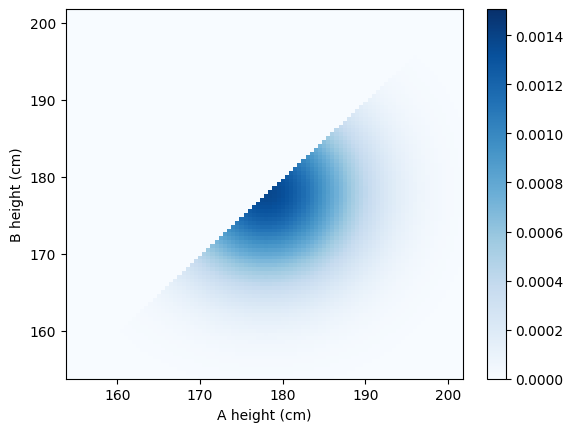

In [28]:
plot_joint(posterior)

In [29]:
# From the joint posterior, the posteriors for A and B can be computed

# Suppose we want to know the probability that A is 180 cm tall: select column from joint posterior where x=180

column = posterior[180]
column.head()

154.0    0.000010
154.5    0.000013
155.0    0.000015
155.5    0.000019
156.0    0.000022
Name: 180.0, dtype: float64

In [30]:
column.sum() # so the probability is about 3% that A is 180 cm tall

np.float64(0.03017221271570807)

In [31]:
# To calculate the posterior for A's height, add up all the columns

column_sums = posterior.sum(axis=0)
column_sums.head()

154.0    0.000000e+00
154.5    1.012260e-07
155.0    2.736152e-07
155.5    5.532519e-07
156.0    9.915650e-07
dtype: float64

In [33]:
# This sum is a probability distribution for A's height, which can be put in a Pmf

marginal_A = Pmf(column_sums)

<Axes: title={'center': 'Posterior distribution for A'}, xlabel='Height (cm)', ylabel='PDF'>

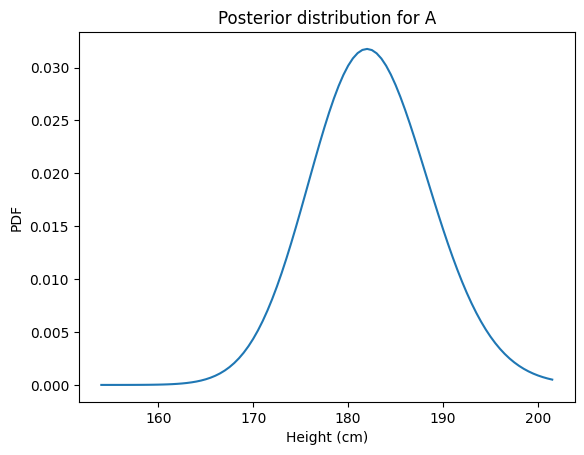

In [34]:
marginal_A.plot(title="Posterior distribution for A", xlabel="Height (cm)", ylabel="PDF")

<Axes: title={'center': 'Posterior distribution for B'}, xlabel='Height (cm)', ylabel='PDF'>

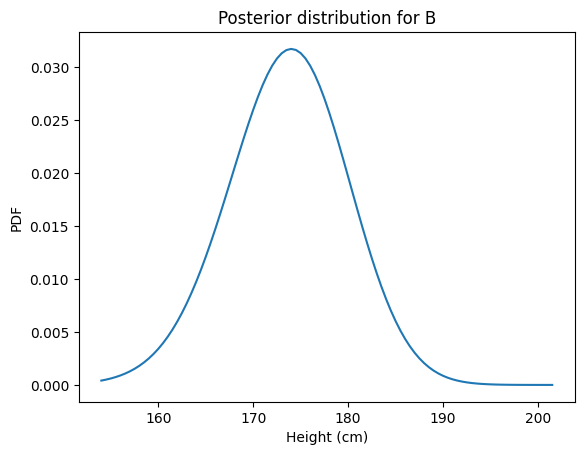

In [35]:
# The posterior for B can be calculated the same way

row_sums = posterior.sum(axis=1)
marginal_B = Pmf(row_sums)

marginal_B.plot(title="Posterior distribution for B", xlabel="Height (cm)", ylabel="PDF")

In [36]:
# This can be formalized into a function

def marginal(joint, axis):
    return Pmf(joint.sum(axis=axis))

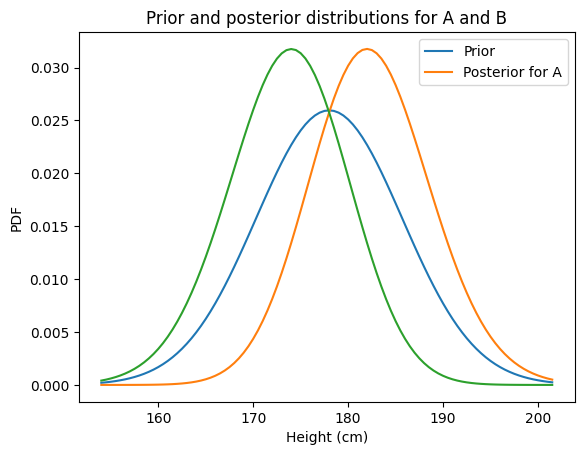

In [37]:
prior.plot(label="Prior", title="Prior and posterior distributions for A and B")
marginal_A.plot(label="Posterior for A", xlabel="Height (cm)", ylabel="PDF")
marginal_B.plot()
plt.legend()

In [38]:
print(f"Prior mean: {prior.mean()}, Posterior for A: {marginal_A.mean()}, Posterior for B: {marginal_B.mean()}")

Prior mean: 177.99516026921506, Posterior for A: 182.3872812342168, Posterior for B: 173.6028600023339


In [39]:
# The posterior SDs are a little narrower than that of the prior

print(f"Prior SD: {prior.std()}, Posterior SD for A: {marginal_A.std()}, Posterior SD for B: {marginal_B.std()}")

Prior SD: 7.624924796641578, Posterior SD for A: 6.270461177645469, Posterior SD for B: 6.280513548175111


In [40]:
# Suppose we measure A and find he is 170 cm

column_170 = posterior[170]

cond_B = Pmf(column_170)
cond_B.normalize()

np.float64(0.004358061205454471)

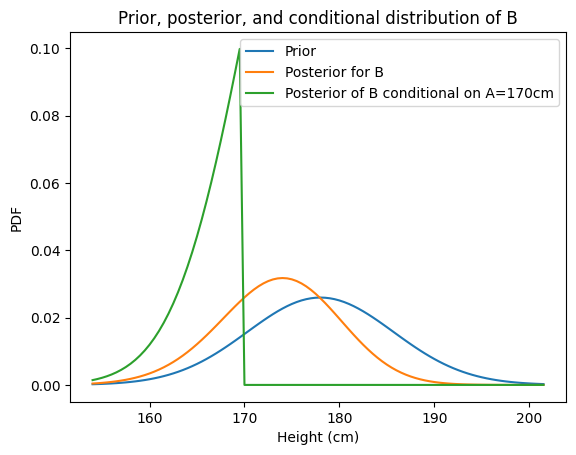

In [42]:
# This lets us estimate a conditional distribution for B knowing that A is 170 cm

prior.plot(label="Prior", title="Prior, posterior, and conditional distribution of B")
marginal_B.plot(label="Posterior for B", xlabel="Height (cm)", ylabel="PDF")
cond_B.plot(label="Posterior of B conditional on A=170cm")
plt.legend()

In [43]:
# Exercise 11-1 - compute a posterior conditional for A if B=180cm

row_180 = posterior.loc[180]

In [44]:
row_180.head()

154.0    0.0
154.5    0.0
155.0    0.0
155.5    0.0
156.0    0.0
Name: 180.0, dtype: float64

In [45]:
cond_A = Pmf(row_180)
cond_A.normalize()

np.float64(0.019669089649708035)

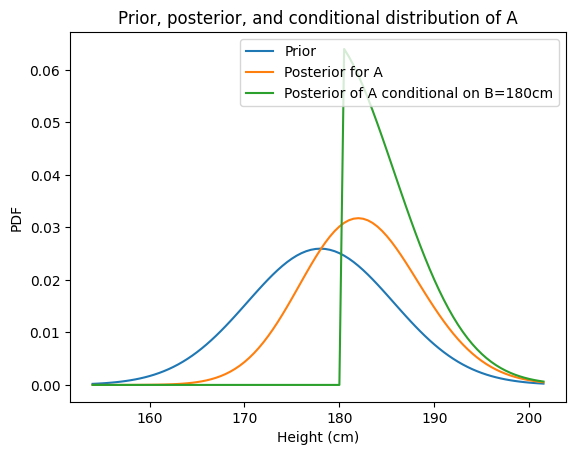

In [46]:
prior.plot(label="Prior", title="Prior, posterior, and conditional distribution of A")
marginal_A.plot(label="Posterior for A", xlabel="Height (cm)", ylabel="PDF")
cond_A.plot(label="Posterior of A conditional on B=180cm")
plt.legend() # THIS IS RIGHT!

In [47]:
# Exercise 11-2

# We know A is taller than B, but not how tall B is
# Choose a random woman C, who is >=15cm shorter than A
# Compute posteriors for A and C
# Given: average height for American women is 163 cm with SD 7.3 cm

mean_w = 163
qs = np.arange(mean-24, mean+24, 0.5)

std_w = 7.3
ps = norm(mean_w, std_w).pdf(qs)

prior_w = Pmf(ps, qs)
prior_w.normalize()

np.float64(1.7949772472502712)

In [49]:
joint_ac = make_joint(prior, prior_w)
joint_ac.shape

(96, 96)

In [50]:
joint_ac.to_numpy().sum()

np.float64(1.0)

In [51]:
x = joint_ac.columns
y = joint_ac.index

X, Y = np.meshgrid(x, y)

A_taller_C = (X - Y >= 15)
a = np.where(A_taller_C, 1, 0)

likelihood_ac = pd.DataFrame(a, index=x, columns=y)

In [52]:
posterior_ac = joint_ac * likelihood_ac
normalize(posterior_ac)

np.float64(0.4596093510776464)

In [53]:
# Posteriors

marginal_A = marginal(posterior_ac, axis=0)
marginal_C = marginal(posterior_ac, axis=1)

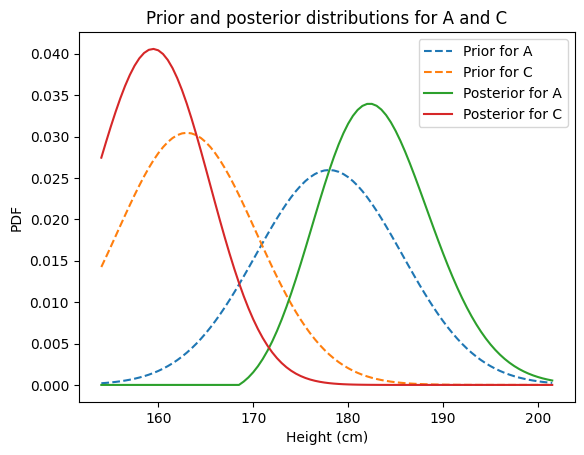

In [54]:
prior.plot(label="Prior for A", title="Prior and posterior distributions for A and C", ls="--")
prior_w.plot(label="Prior for C", ls="--")
marginal_A.plot(label="Posterior for A", xlabel="Height (cm)", ylabel="PDF")
marginal_C.plot(label="Posterior for C")
plt.legend()

In [55]:
print(marginal_A.mean(), marginal_C.mean()) # ONE MISTAKE: USING THE PRIOR FOR A INSTEAD OF THE POSTERIOR FROM THE PRECEDING ANALYSIS

183.14780703097097 161.14345616226942


In [56]:
print(prior.mean(), prior_w.mean())

177.99516026921506 164.45378391407127


In [57]:
# Exercise 11-3

# Player A has a rating of 1600 that we aren't sure about. We can describe their rating with a normal 
# distribution with mean 1600 and SD 100
# Player B has a rating of 1800 with the same SD 100
# A and B play and A wins. How should their ratings be updated?

# Construct prior for A

mean_a = 1600
qs_a = np.arange(mean_a-300, mean_a+300, 10)

std_a = 100
ps_a = norm(mean_a, std_a).pdf(qs_a)

prior_a = Pmf(ps_a, qs_a)
prior_a.normalize()

# Construct prior for B

mean_b = 1800
qs_b = np.arange(1500, 2100, 10)

std_b = 100
ps_b = norm(mean_b, std_b).pdf(qs_b)

prior_b = Pmf(ps_b, qs_b)
prior_b.normalize()

np.float64(0.09972780668486173)

In [58]:
joint_ab = make_joint(prior_a, prior_b)
joint_ab.to_numpy().sum()

np.float64(1.0)

In [70]:
# Likelihood, which is the probability of observing the data under every hypothesis
# Or, Pr(A wins | every possible combination of A and B ratings)

x = joint_ab.columns
y = joint_ab.index

X, Y = np.meshgrid(x, y)
diff = X - Y

p_Awin = 1 / (1 + 10**(-diff/400))

likelihood_ab = pd.DataFrame(p_Awin, index=y, columns=x)

In [71]:
# Bayesian update

posterior_ab = joint_ab * likelihood_ab
normalize(posterior_ab)

np.float64(0.2660426288107942)

In [72]:
# Posteriors

marginal_A = marginal(posterior_ab, axis=0)
marginal_B = marginal(posterior_ab, axis=1)

In [73]:
print(prior_a.mean(), marginal_A.mean())

1599.8666816640437 1636.648345528236


In [74]:
print(prior_b.mean(), marginal_B.mean())

1799.8666816640434 1763.0203078793095


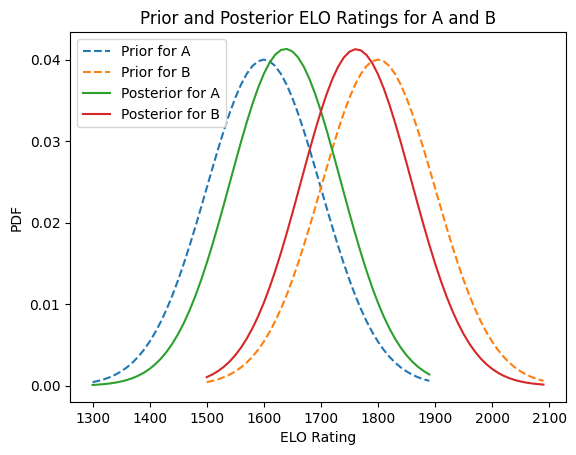

In [75]:
prior_a.plot(label="Prior for A", title="Prior and Posterior ELO Ratings for A and B", ls="--")
prior_b.plot(label="Prior for B", ls="--")
marginal_A.plot(label="Posterior for A", xlabel="ELO Rating", ylabel="PDF")
marginal_B.plot(label="Posterior for B")
plt.legend() # THIS IS RIGHT, THOUGH NEEDED A LITTLE HELP ON THE LIKELIHOOD